
[시계열 전처리 2: 결측치 보간 (Interpolation)]에 대한 상세 강의 자료와 실습 노트북이다.

이 시간의 핵심은 "데이터가 비어있을 때, 단순히 평균으로 채우는 것이 아니라 '시간의 흐름'을 고려해서 채우는 방법"을 배우는 것이다. 헬스케어 데이터는 연속성이 중요하므로 보간법(Interpolation)은 필수적인 기술이다.

---

# 📘시계열 데이터의 빈칸 채우기: 보간 (Interpolation)

## 1. 결측치(NaN)가 시계열에서 더 위험한 이유
*   비시계열(Day 1): 특정 환자의 데이터가 비어있으면 그 환자를 빼고 분석해도 된다(Row Drop).
*   시계열(Day 2): 시간 흐름이 생명이다. 중간에 데이터가 빠지면 그래프가 끊어진다.
    *   *예시:* 10시와 12시 데이터는 있는데 11시가 없으면, 10시에서 12시로 어떻게 변했는지 추세를 계산할 수 없다.
    *   따라서 시계열에서는 삭제(Drop)보다는 채우기(Fill)를 우선적으로 고려한다.

## 2. 채우는 방법의 차이: 대체(Imputation) vs 보간(Interpolation)
1.  단순 대체 (Imputation):
    *   "전체 기간의 평균값"으로 채운다.
    *   *문제점:* 환자의 체온이 아침엔 낮고 오후엔 높을 수 있는데, 11시의 빈칸을 '하루 평균'으로 채우면 시간적 맥락이 무시된다.
2.  보간 (Interpolation):
    *   "앞뒤 문맥"을 보고 빈칸을 추론한다.
    *   "10시 체온이 36.5도, 12시 체온이 37.5도라면, 11시는 대략 37.0도쯤이지 않았을까?"라고 합리적으로 추측하여 채운다.

## 3. 주요 보간 기법 (Methods)
1.  선형 보간 (Linear Interpolation):
    *   점과 점 사이를 직선으로 연결한다.
    *   가장 안전하고 보편적인 방법이다. 체온, 혈당처럼 서서히 변하는 지표에 적합하다.
2.  시간 흐름 보간 (Time Interpolation):
    *   데이터의 시간 간격이 불규칙할 때 필수적이다.
    *   *상황:* 데이터가 [9:00, 9:10, 12:00] 이렇게 있다. 9:10과 12:00 사이는 매우 멀다. 일반 선형 보간은 이를 무시하지만, 시간 보간은 이 '거리'를 반영하여 기울기를 조절한다.
3.  이전 값 채우기 (Forward Fill - ffill):
    *   직전의 유효한 값을 그대로 다음 빈칸에 복사한다.
    *   약물 투여(Dosage)나 설정값(Settings)처럼, "바꾸기 전까지는 유지되는 데이터"에 적합하다.

---
---

# 💻 끊어진 맥박 잇기 (Interpolation)

이 노트북에서는 중간중간 데이터가 유실된 환자 데이터를 생성하고, 이를 다양한 방법으로 복구해보며 그 차이를 시각적으로 확인한다.

### 1. 환경 설정 및 결측이 포함된 데이터 생성
10분 간격의 체온 데이터를 생성하되, 중간중간 데이터를 지워서(NaN) 불완전한 시계열을 만든다.

















결측치가 포함된 데이터(일부):


/tmp/ipython-input-1560346340.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_idx = pd.date_range('2025-01-01 12:00', '2025-01-01 18:00', freq='10T')


,Temp
2025-01-01 12:00:00,36.549671
2025-01-01 12:10:00,NaN
2025-01-01 12:20:00,NaN
2025-01-01 12:30:00,36.818970
2025-01-01 12:40:00,NaN
2025-01-01 12:50:00,NaN
2025-01-01 13:00:00,36.991255
2025-01-01 13:10:00,36.965632
2025-01-01 13:20:00,36.897497
2025-01-01 13:30:00,37.054256


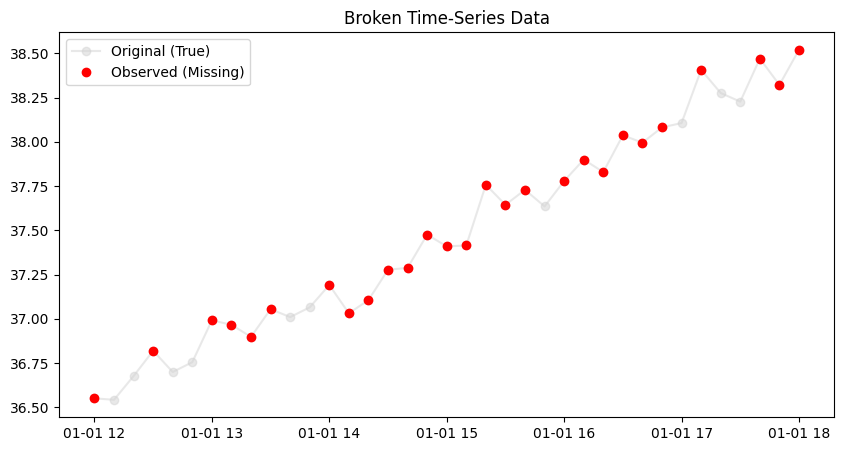

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2025년 1월 1일 12시부터 18시까지 10분 간격 시간 생성
time_idx = pd.date_range('2025-01-01 12:00', '2025-01-01 18:00', freq='10T')

# 정상적인 체온 흐름 생성 (서서히 오르는 추세)
np.random.seed(42)
temp_clean = np.linspace(36.5, 38.5, len(time_idx)) + np.random.normal(0, 0.1, len(time_idx))

df = pd.DataFrame({'Temp': temp_clean}, index=time_idx)

# 데이터 구멍 뚫기 (Missing Value Injection)
# 랜덤하게 10개의 데이터를 지운다.
df_missing = df.copy()
missing_idx = np.random.choice(df.index, 10, replace=False)
df_missing.loc[missing_idx, 'Temp'] = np.nan

print("결측치가 포함된 데이터(일부):")
display(df_missing.head(10))

# 시각화: 끊어진 그래프 확인
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Temp'], 'o-', color='lightgray', label='Original (True)', alpha=0.5)
plt.plot(df_missing.index, df_missing['Temp'], 'o', color='red', label='Observed (Missing)')
plt.title("Broken Time-Series Data")
plt.legend()
plt.show()

### 2. Forward Fill (이전 값으로 채우기)
가장 단순한 방법이다. 결측치 바로 직전의 값을 가져와서 채운다. 계단 모양의 그래프가 형성된다.

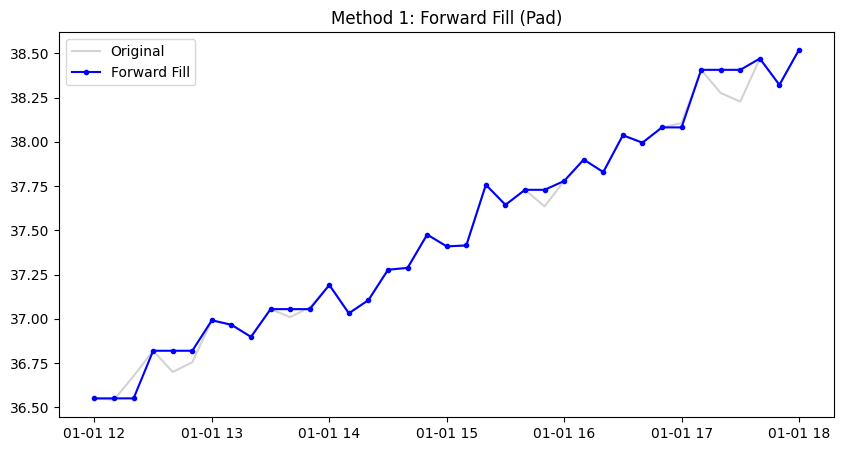

In [2]:
# ffill() 사용
df_ffill = df_missing.ffill()

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Temp'], color='lightgray', label='Original')
# ffill 결과 시각화
plt.plot(df_ffill.index, df_ffill['Temp'], '.-', color='blue', label='Forward Fill')
plt.title("Method 1: Forward Fill (Pad)")
plt.legend()
plt.show()

# 해석: 계단식으로 채워지므로, 체온처럼 연속적으로 변하는 데이터에는 부자연스러울 수 있다.
# 하지만 "산소마스크 농도 세팅" 같은 데이터라면 이 방법이 맞다.

### 3. Linear Interpolation (선형 보간)
비어있는 구간의 시작점과 끝점을 직선으로 연결한다. Vital Sign 데이터 복구에 가장 많이 쓰인다.

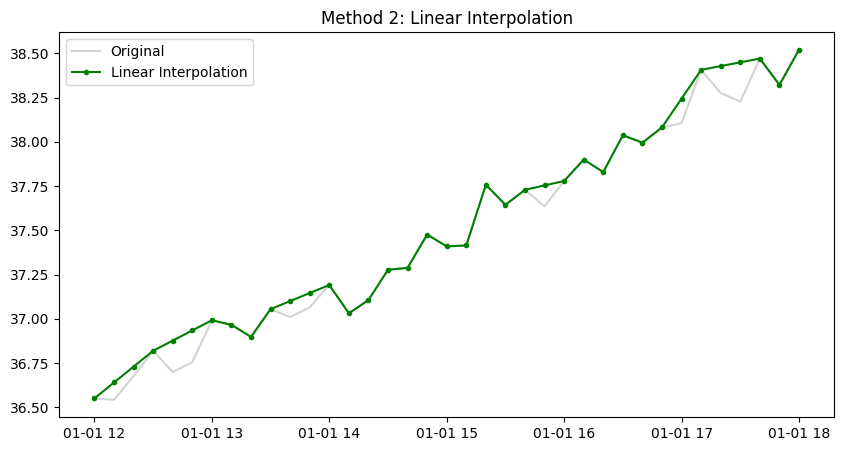

In [3]:
# interpolate(method='linear') 사용
df_linear = df_missing.interpolate(method='linear')

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Temp'], color='lightgray', label='Original')
# Linear 보간 결과 시각화
plt.plot(df_linear.index, df_linear['Temp'], '.-', color='green', label='Linear Interpolation')
plt.title("Method 2: Linear Interpolation")
plt.legend()
plt.show()

# 해석: ffill보다 훨씬 자연스럽게 원본 데이터(회색)의 흐름을 따라가는 것을 볼 수 있다.

### 4. Time Interpolation (시간 흐름 반영 보간)
심화: 만약 데이터 수집 간격이 불규칙하다면 어떻게 될까?
`linear`는 단순히 인덱스의 순서(첫 번째, 두 번째...)만 따지지만, `time`은 실제 시간 간격을 계산에 넣는다.

[불규칙 시계열 데이터]


,Temp
2025-01-01 12:00:00,36.5
2025-01-01 12:05:00,NaN
2025-01-01 14:00:00,NaN
2025-01-01 14:10:00,38.0



[보간 결과 비교]


,Linear,Time
2025-01-01 12:00:00,36.5,36.500000
2025-01-01 12:05:00,37.0,36.557692
2025-01-01 14:00:00,37.5,37.884615
2025-01-01 14:10:00,38.0,38.000000


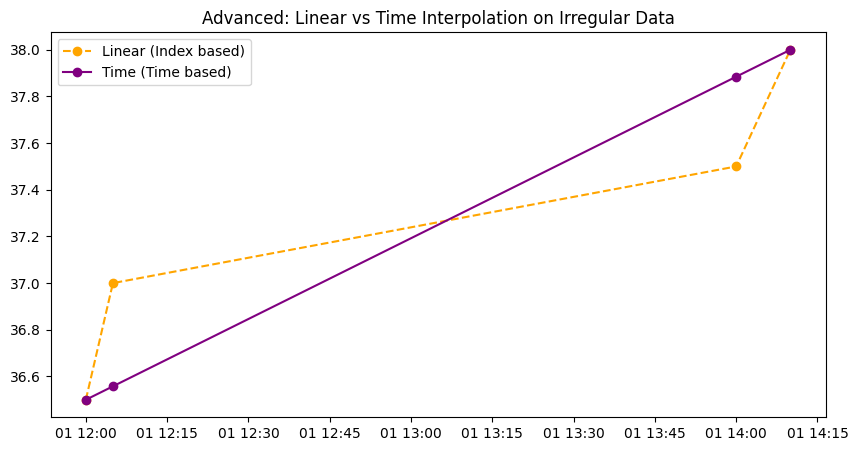

In [4]:
# 불규칙한 데이터셋 생성 (시간 간격이 제각각임)
irregular_idx = pd.to_datetime([
    '2025-01-01 12:00',
    '2025-01-01 12:05',  # 5분 차이
    '2025-01-01 14:00',  # 약 2시간 차이 (결측 구간이 김)
    '2025-01-01 14:10'   # 10분 차이
])
vals = [36.5, np.nan, np.nan, 38.0] # 중간 두 개가 비어있음
df_irr = pd.DataFrame({'Temp': vals}, index=irregular_idx)

print("[불규칙 시계열 데이터]")
display(df_irr)

# 비교 1: 그냥 Linear (시간 무시, 순서대로 등간격 가정)
res_linear = df_irr.interpolate(method='linear')

# 비교 2: Time (시간 간격 비례)
res_time = df_irr.interpolate(method='time')

# 결과 비교 출력
comp_df = pd.DataFrame({
    'Linear': res_linear['Temp'],
    'Time': res_time['Temp']
})
print("\n[보간 결과 비교]")
display(comp_df)

# 시각화 비교
plt.figure(figsize=(10, 5))
plt.plot(res_linear.index, res_linear['Temp'], 'o--', label='Linear (Index based)', color='orange')
plt.plot(res_time.index, res_time['Temp'], 'o-', label='Time (Time based)', color='purple')
plt.title("Advanced: Linear vs Time Interpolation on Irregular Data")
plt.legend()
plt.show()

### 📝 실습 과제 및 주의사항
위에서 배운 내용을 바탕으로 다음 상황을 해결해본다.

1.  `df_missing` 데이터에서 맨 첫 번째 행(12:00)의 데이터를 강제로 `NaN`으로 만든다. (`df_missing.iloc[0, 0] = np.nan`)
2.  이 상태에서 `interpolate()`를 실행해본다. 첫 번째 값은 채워지는가?
3.  채워지지 않는다면 어떻게 해결해야 하는가? (힌트: `bfill`을 조합한다.)

In [5]:
# [실습 답안 예시]

# 1. 첫 데이터 삭제
df_test = df_missing.copy()
df_test.iloc[0, 0] = np.nan

# 2. 보간 실행 (선형 보간)
# 선형 보간은 '양쪽 점'이 있어야 그 사이를 잇는데, 첫 점이 없으면 시작을 못 한다.
df_filled = df_test.interpolate(method='linear')

print("첫 번째 행 보간 여부 확인:")
print(df_filled.head(3)) # 첫 행은 여전히 NaN일 것이다.

# 3. 해결책: 보간 후 남은 앞/뒤 끝부분은 bfill/ffill로 메꾼다.
df_final = df_filled.bfill().ffill()

print("\n최종 보완 후:")
print(df_final.head(3))

첫 번째 행 보간 여부 확인:
                     Temp
2025-01-01 12:00:00   NaN
2025-01-01 12:10:00   NaN
2025-01-01 12:20:00   NaN

최종 보완 후:
                         Temp
2025-01-01 12:00:00  36.81897
2025-01-01 12:10:00  36.81897
2025-01-01 12:20:00  36.81897
